# **Redes Neuronales Artificiales / Binary** 

## **1. Initial Configuration**

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
import seaborn as sns

# Load dataset
url = 'https://raw.githubusercontent.com/jorge-robledo11/Datasets/main/Datasets/Churn_Modelling.csv'
dataset = pd.read_csv(url, encoding='utf-8')
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [2]:
# Evitar warnings
import warnings
warnings.filterwarnings('ignore')

# Seed
seed = 1337
np.random.seed(seed)

# Dataset copy
data = dataset.copy()

### **Split into features and target**

In [3]:
# Split into features 'X' and target 'y'
array = data.values
X = array[:, 3:13]
y = array[:, 13]

## **2. Data Preprocessing**

In [4]:
# Coding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Labeling
le = LabelEncoder()
X[:, 1] = le.fit_transform(X[:, 1])
X[:, 2] = le.fit_transform(X[:, 2])

# Transforming
"""
Transformamos la columna 1 del dataset con un One-Hot encoding
"""
ct = ColumnTransformer([('Country', OneHotEncoder(handle_unknown='ignore'), [1])], remainder='passthrough', n_jobs=-1)
X = ct.fit_transform(X)
X = X[:, 1:]

X = X.astype(float)
y = y.astype(int)

# Bias
print('Bias')
X = pd.DataFrame(X)
X.skew().sort_values()

Bias


8    -0.901812
3    -0.183596
6    -0.141109
2    -0.071607
9    -0.060437
10    0.002085
5     0.010991
7     0.745568
4     1.011320
0     1.149340
1     1.169106
dtype: float64

### **Scale and reduce bias**

In [5]:
# Numerical
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import PowerTransformer

numerical_pipe = Pipeline([
    ('Imputer', KNNImputer()),
    ('Transfomer', PowerTransformer()),
    ('Scaler', StandardScaler())
])

# Categorical
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

numerical = list(X.select_dtypes(exclude=['object']))
categorical = list(X.select_dtypes(include=['object']))

# Transformer
full_pipe = ColumnTransformer([
    ('Números', numerical_pipe, numerical),
    ('Categorías', OneHotEncoder(), categorical)
])

# Transform
X = full_pipe.fit_transform(X.values)

# Bias
print('Bias')
X = pd.DataFrame(X)
X.skew().sort_values()

Bias


8    -0.901812
6    -0.555956
10   -0.290537
3    -0.183596
5    -0.176025
9    -0.060437
2    -0.025403
4    -0.002495
7     0.151289
0     1.149340
1     1.169106
dtype: float64

### **Split into train and test set**

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# K-Fold
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Casting to Dataframe
X = pd.DataFrame(X)
y = pd.DataFrame(y)

for train, test in kfold.split(X, y):

    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]

# Train & Test
print('Train data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)
print()

# Test & Validation
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed, shuffle=True)
print('Train data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)
print('Validation data:', X_val.shape, y_val.shape)

# Casting to Numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

Train data: (9000, 11) (9000, 1)
Test data: (1000, 11) (1000, 1)

Train data: (9000, 11) (9000, 1)
Test data: (500, 11) (500, 1)
Validation data: (500, 11) (500, 1)


## **3. Build model**

In [7]:
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from keras.optimizers import gradient_descent_v2

# Baseline Model
model = Sequential()
model.add(Dropout(0.2, input_shape=(11,)))
model.add(Dense(32, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Stochastic Gradient Descent / Optimizer
sgd = gradient_descent_v2.SGD(lr=0.01, momentum=0.9)

# Compile
model.compile(loss='binary_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])

# Fit
history = model.fit(X, y, validation_split=0.3, batch_size=32, epochs=200, verbose=0)

# Dictionary all data in history
print(history.history.keys())

# Evaluate
eval = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
print(f'Loss: {round(eval[0]*100, 2)}%')
print(f'Accuracy: {round(eval[1]*100, 2)}%')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Loss: 38.82%
Accuracy: 83.2%


### **Train Analysis**

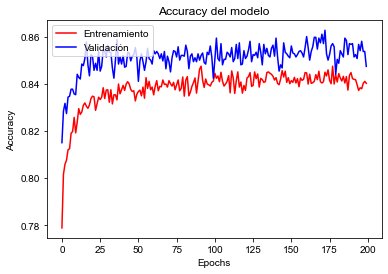

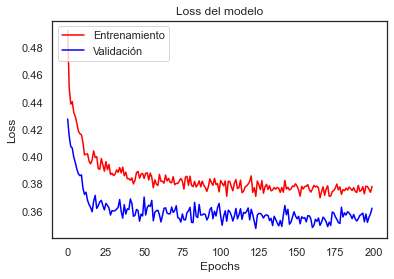

In [8]:
%matplotlib inline
# Summarize history for accuracy
plt.plot(history.history['accuracy'], c='red')
plt.plot(history.history['val_accuracy'], c='blue')
plt.title('Accuracy del modelo')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
sns.set_theme(style='white', palette='deep', color_codes=True)
plt.show();

# Summarize history for loss
plt.plot(history.history['loss'], c='red')
plt.plot(history.history['val_loss'], c='blue')
plt.title('Loss del modelo')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
sns.set_theme(style='white', palette='deep', color_codes=True)
plt.show();

## **4. Evaluate**

In [9]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Baseline Model
def baseline_model():
    
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(11,)))
    model.add(Dense(32, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Stochastic Gradient Descent / Optimizer
    sgd = gradient_descent_v2.SGD(lr=0.01, momentum=0.9)

    # Compile
    model.compile(loss='binary_crossentropy',
                    optimizer=sgd,
                    metrics=['accuracy'])

    return model

# Stratified K-Fold
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# Classifier
classifier = KerasClassifier(build_fn=baseline_model, batch_size=32, epochs=200)

# Results
accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=skfold, n_jobs=-1)
means = np.mean(accuracies)*100
variances = np.std(accuracies)*100

print('Baseline model')
print(f'Accuracy: {round(means, 2)}%')
print(f'Variance: {round(variances, 2)}%')

Baseline model
Accuracy: 85.07%
Variance: 0.57%


### **Predict**

In [10]:
# Prediction
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

### **Confusion Matrix**

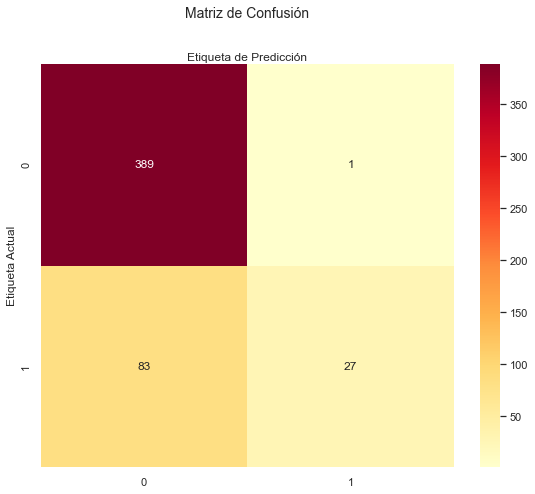

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Labels
class_names = [0,1]
fig, ax = plt.subplots(figsize=(8,7)) 
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names) 

# Confusion Matrix
sns.heatmap(pd.DataFrame(cm), annot = True, cmap='YlOrRd', fmt='g')
ax.xaxis.set_label_position('top')
plt.title('Matriz de Confusión', y=1.1, fontsize=14)
plt.ylabel('Etiqueta Actual', fontsize=12)
plt.xlabel('Etiqueta de Predicción', fontsize=12)
plt.tight_layout();

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score

# Validation Set
print(classification_report(y_val, y_pred))
print(f'Precision Score: {round(precision_score(y_val, y_pred, average="weighted")*100, 2)}%')
print(f'Accuracy Score: {round(accuracy_score(y_val, y_pred)*100, 2)}%')
print(f'F1 Score Score: {round(f1_score(y_val, y_pred, average="weighted")*100, 2)}%')
print(f'Kappa Score: {round(cohen_kappa_score(y_val, y_pred)*100, 2)}%')

              precision    recall  f1-score   support

           0       0.83      0.95      0.88       410
           1       0.29      0.09      0.14        90

    accuracy                           0.80       500
   macro avg       0.56      0.52      0.51       500
weighted avg       0.73      0.80      0.75       500

Precision Score: 72.9%
Accuracy Score: 79.6%
F1 Score Score: 74.96%
Kappa Score: 5.49%
